In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
codes_dir = pathlib.Path('./code')
embedding_dir = pathlib.Path('./embeddings')

## Dataset Overview

In [3]:
antipatterns = list(codes_dir.glob('*'))
print(f'There are a total of {len(antipatterns)} antipatterns')

There are a total of 4 antipatterns


In [4]:
antipatterns_dict = {}
for antipattern in antipatterns:
    antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))
    print(f'Antipattern {antipattern.name} has {len(antipatterns_dict[antipattern.name])} samples')

Antipattern data_class has 399 samples
Antipattern feature_envy has 1061 samples
Antipattern god_classes has 313 samples
Antipattern parallel_inheritance_hierarchies has 266 samples


## Lines of code

Firstly, let's review the lines of code present. We have a Java code, so we only need to clean comments from this language

In [5]:
import re
def removeComments(string):
    string = re.sub(re.compile("/\*.*?\*/",re.DOTALL ) , "" ,string) # remove all occurrences streamed comments (/*COMMENT */) from string
    string = re.sub(re.compile("//.*?\n" ) ,"" ,string) # remove all occurrence single-line comments (//COMMENT\n ) from string
    return string

def handleLines(lines):
    return list(filter(lambda x: x, [k.strip() for k in removeComments(' '.join(lines)).split('\n')]))

In [6]:
number_of_lines = defaultdict(list)
for name, values in tqdm(antipatterns_dict.items()):
    for item in values:
        number_of_lines[name].append(len(handleLines(item.open('r').readlines())))

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


After computing the code length for each file we can check some statistics

In [7]:
for name, values in number_of_lines.items():
    print(f"Antipattern {name}. Length of code. Mean {np.mean(values):.2f}. Min {np.min(values)}. Max {np.max(values)}")

Antipattern data_class. Length of code. Mean 461.67. Min 21. Max 3784
Antipattern feature_envy. Length of code. Mean 247.65. Min 15. Max 3784
Antipattern god_classes. Length of code. Mean 651.48. Min 117. Max 3784
Antipattern parallel_inheritance_hierarchies. Length of code. Mean 210.88. Min 5. Max 3784


Overall, the number of lines of code is quite high, this may be a problem down the line for the code2vec model and overall any NLP model, as they may forget some lines that were very far away. We can also see that some files are very small (definitely an outlier, most likely no antipattern is present there) and some are very large (most likely, **god classes**)

Let's see the distribution of the length for each antipattern and then the overall dataset that we have so far.

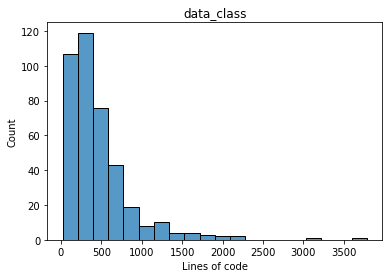

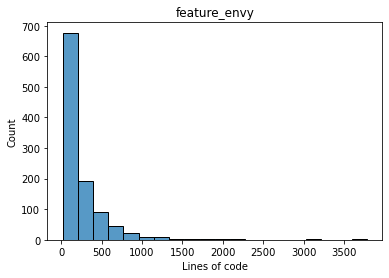

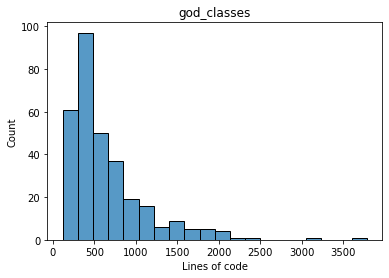

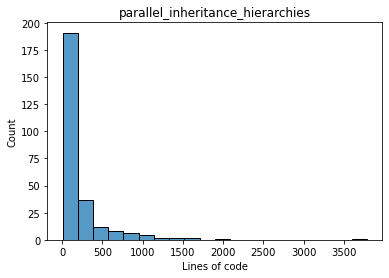

In [8]:
for name, value in number_of_lines.items():
    sns.histplot(x=value, bins=20)
    plt.title(name)
    plt.xlabel('Lines of code')
    plt.show()

As we can see most of the samples are below 500 lines of code. Very little of them are above 2500. We may want to remove them or let them be and check if it will affect the quality of the prediction for those samples.

## Java constructs

Another idea for checking is how many fuctions, constructors and overall other java constructs are present in the code (again can be a symbol for detecting a god class)

In [11]:
from ripgrepy import Ripgrepy
# Ripgrepy is very fast for regular expressions

# This is very naiive approach at detecting function and contrusctors, but it will do for our analysis
# Please don't ask me how I've created it
java_constructs = '^\s*(?:protected|private|package-private|public|String|int)\s*(?:\s*[a-zA-Z0-9]+)*\s*(?:[a-zA-Z0-9]+)\s*\(.*?\)\s*\{$'
def get_num_of_constructs(filename):
    rg = Ripgrepy(java_constructs, filename)
    return len(rg.line_number().json().run().as_dict)

In [12]:
number_of_constructs = defaultdict(list)
for name, values in tqdm(antipatterns_dict.items()):
    for item in values:
        number_of_constructs[name].append(get_num_of_constructs(item))

100%|██████████| 4/4 [00:42<00:00, 10.55s/it]


In [13]:
for name, values in number_of_constructs.items():
    print(f"Antipattern {name}. Number of functions. Mean {np.mean(values):.2f}. Min {np.min(values)}. Max {np.max(values)}")

Antipattern data_class. Number of functions. Mean 24.68. Min 0. Max 324
Antipattern feature_envy. Number of functions. Mean 13.10. Min 0. Max 324
Antipattern god_classes. Number of functions. Mean 31.30. Min 0. Max 324
Antipattern parallel_inheritance_hierarchies. Number of functions. Mean 10.49. Min 0. Max 324


We cann see that in general, there aren't that many fucntions (judging by java standards). However, some files doesn't seem to have any. We would need to look at them further when cleaning the data

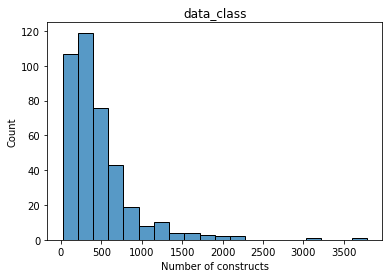

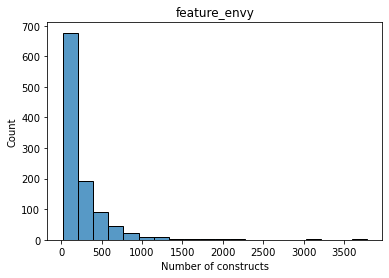

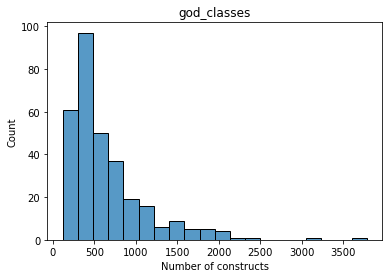

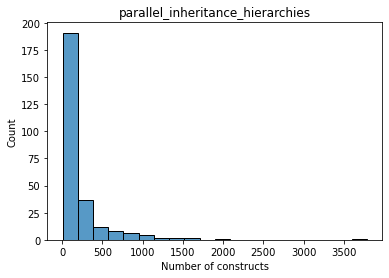

In [14]:
for name, value in number_of_lines.items():
    sns.histplot(x=value, bins=20)
    plt.title(name)
    plt.xlabel('Number of constructs')
    plt.show()

Looking at the distribution we already can notice some interesting things. God classes tend to have a lot of them, then others! This actually may be a useful feature when adding some information in addition to the code2vec model

## T-SNE

As we have already computed embedding for those code snippets we may want to analyze T-SNE of them and see if there are any conclusion to be made or obvious clusters of items

Unfortunately, they have variable size, so for now I'll naiively cut them by some threshold and pad to maximum. Obviously this doesn't represent the code as a whole, but we may try to get some insight about the embeddings

In [37]:
antipatterns = list(embedding_dir.glob('*'))
antipatterns_dict = {}
for antipattern in antipatterns:
    antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))

In [55]:
def get_embedding(filename):
    return np.array([float(x) for x in filename.open().read().split()])

thresh = 10000
embeds = []
labels = []
name2label = {name:i for name, i in zip(antipatterns_dict, range(len(antipatterns_dict)))}
for name, files in antipatterns_dict.items():
    for file in files:
        emb = get_embedding(file)
        if len(emb) > thresh:
            embeds.append(emb[:thresh])
            labels.append(name2label[name])
        else:
            embeds.append(np.pad(emb, (0, thresh-len(emb)), 'constant', constant_values=(0,)))
            labels.append(name2label[name])

In [57]:
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
tsne_vectors = tsne.fit_transform(np.array(embeds))

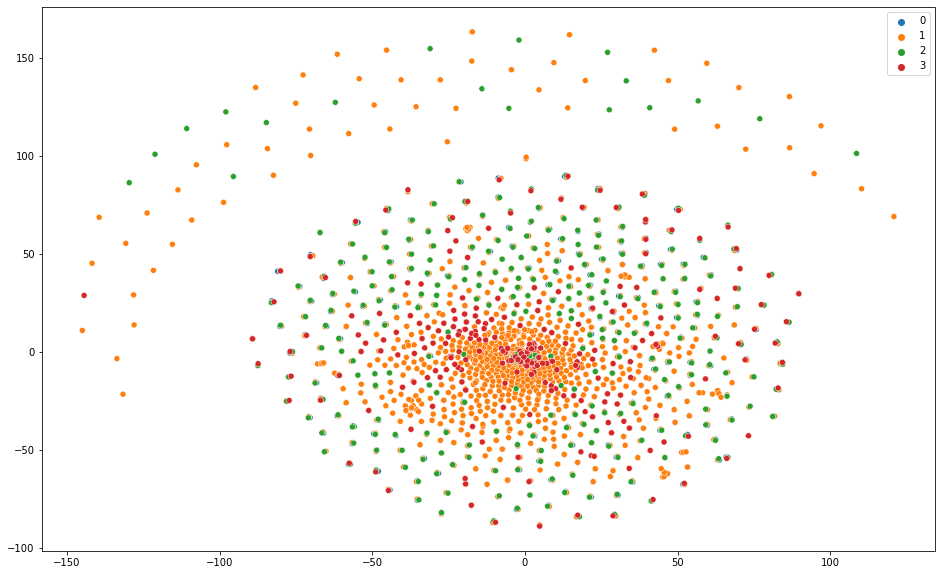

In [58]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_vectors[:, 0], y=tsne_vectors[:, 1], hue=labels, palette=sns.color_palette("tab10")[:4])
plt.show()

As was predicted, there isn't much to be drawn out from this plot, but we may see some clusters in the center, which may be the clusters for our problem